In [2]:
import pandas as pd

blood_transfusion = pd.read_csv("../datasets/blood_transfusion.csv")
target_name = "Class"
data = blood_transfusion.drop(columns=target_name)
target = blood_transfusion[target_name]

In [3]:
blood_transfusion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Recency    748 non-null    int64 
 1   Frequency  748 non-null    int64 
 2   Monetary   748 non-null    int64 
 3   Time       748 non-null    int64 
 4   Class      748 non-null    object
dtypes: int64(4), object(1)
memory usage: 29.3+ KB


In [4]:
blood_transfusion.head()

,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,98,donated
1,0,13,3250,28,donated
2,1,16,4000,35,donated
3,2,20,5000,45,donated
4,1,24,6000,77,not donated


### Q1.
- The problem to be solved is a binary classification problem (exactly 2 possible classes)
- The proportions of the class counts are imbalanced: some classes have more than twice as many rows than others 

In [13]:
target.value_counts(normalize=1)

not donated    0.762032
donated        0.237968
Name: Class, dtype: float64

#### Q2. 
Using a sklearn.dummy.DummyClassifier and the strategy "most_frequent", what is the average of the accuracy scores obtained by performing a 10-fold cross-validation?



In [16]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

dummy = DummyClassifier(strategy='most_frequent')
scores = cross_val_score(dummy, data, target, cv = 10, error_score='raise')
scores.mean()

0.762054054054054

#### Q3. 
Repeat the previous experiment but compute the balanced accuracy instead of the accuracy score. Pass scoring="balanced_accuracy" when calling cross_validate or cross_val_score functions, the mean score is:

In [20]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate

dummy = DummyClassifier(strategy='most_frequent')
scores = cross_validate(dummy, data, target, scoring = 'balanced_accuracy', cv = 10, error_score= 'raise')
scores['test_score'].mean()

# In this case, the score is corrected such that such a dummy approach will give a score of 50%. 
# balanced_accuracy makes it easier to distinguish good from bad classifiers on imbalanced classification problems.

0.5

### Q4 
We will use a sklearn.neighbors.KNeighborsClassifier for the remainder of this quiz.
Why is it relevant to add a preprocessing step to scale the data using a StandardScaler when working with a KNeighborsClassifier?

k-nearest neighbors is based on computing some distances. Features need to be normalized to contribute approximately equally to the distance computation. 

### Q5 
Create a scikit-learn pipeline (using sklearn.pipeline.make_pipeline) where a StandardScaler will be used to scale the data followed by a KNeighborsClassifier. Use the default hyperparameters.

Inspect the parameters of the created pipeline. What is the value of K, the number of neighbors considered when predicting with the k-nearest neighbors?

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

model = make_pipeline(StandardScaler(), KNeighborsClassifier())
model.get_params()


{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

### Q6 
Set n_neighbors=1 in the previous model and evaluate it using a 10-fold cross-validation. Use the balanced accuracy as a score. What can you say about this model? Compare the average of the train and test scores to argument your answer.

In [33]:
model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))

cv_result_1 = cross_validate(model, data, target, cv = 10, scoring='balanced_accuracy', return_train_score=True)
cv_result_2 = cross_validate(model, data, target, cv = 10, return_train_score=True)


print('cv_result_1 train and test means: {}, {}'. format(round(cv_result_1['train_score'].mean(), 3),
                                                         round(cv_result_1['test_score'].mean(), 3)))
print('cv_result_2 train and test means: {}, {}'. format(round(cv_result_2['train_score'].mean(), 3),
                                                         round(cv_result_2['test_score'].mean(), 3)))


cv_result_1 train and test means: 0.888, 0.473
cv_result_2 train and test means: 0.926, 0.58


### Q7
We will now study the effect of the parameter n_neighbors on the train and test score using a validation curve. You can use the following parameter range:

param_range = [1, 2, 5, 10, 20, 50, 100, 200, 500]

Also, use a 5-fold cross-validation and compute the balanced accuracy score instead of the default accuracy score (check the scoring parameter). Finally, plot the average train and test scores for the different value of the hyperparameter. We recall that the name of the parameter can be found using model.get_params().

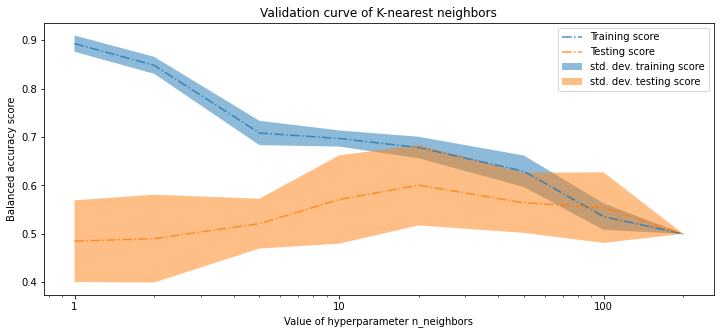

In [39]:
from sklearn.model_selection import validation_curve
import matplotlib
import matplotlib.pyplot as plt


param_range = [1, 2, 5, 10, 20, 50, 100, 200, 500]
param_name = 'kneighborsclassifier__n_neighbors'
train_scores, test_scores = validation_curve(model, data, target, param_name=param_name, param_range=param_range,
                                             cv = 5, scoring='balanced_accuracy', n_jobs=2)
_, ax = plt.subplots(figsize = (12, 5))
for name, scores in zip(
    ["Training score", "Testing score"], [train_scores, test_scores]
):
    ax.plot(
        param_range, scores.mean(axis=1), linestyle="-.", label=name,
        alpha=0.8)
    ax.fill_between(
        param_range, scores.mean(axis=1) - scores.std(axis=1),
        scores.mean(axis=1) + scores.std(axis=1),
        alpha=0.5, label=f"std. dev. {name.lower()}")

ax.set_xticks(param_range)
ax.set_xscale("log")
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel("Value of hyperparameter n_neighbors")
ax.set_ylabel("Balanced accuracy score")
ax.set_title("Validation curve of K-nearest neighbors")
_ = ax.legend(bbox_to_anchor=(1., 1.))
